In [1]:
import yaml

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import create_model, pull_data, fit_give, estimate_population_uncertainty
from electronfactors.visuals.utilities import create_green_cm

In [2]:
green_cm = create_green_cm()

def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

In [4]:
def create_histogram(data):
    plt.figure(figsize=(6 * 1.618, 6))
    
    bins = np.arange(-1.5, 2, 0.5)
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - data),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):
        binRef = (binNum == i)
        representative_height[binRef] = np.arange(sum(binRef)) + 1

    plt.hist(data, bins, alpha=0.6, lw=2)
    plt.scatter(data, representative_height, zorder=2, s=120, alpha=0.8, lw=1.5)
    
    uncertainty = estimate_population_uncertainty(data)
    
    print("Mean = %0.2f" % (np.mean(data)))
    print("Uncertainty = %0.2f" % (uncertainty))

In [5]:
def display_fit(width, eqPonA, factor, model):
    plt.figure(figsize=(6 * 1.618, 6))
    x = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.05)
    y = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.005)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    outOfTolerance = (give > 0.5)

    zz[outOfTolerance] = np.nan

    c = plt.contourf(xx, yy, zz, 100, alpha=1)
    plt.colorbar(c)

    plt.contour(xx, yy, give, levels=[0.5], colors='g')

    plt.scatter(width, eqPonA, s=45, alpha=0.9, zorder=3)

    plt.xlabel(r'Width (cm)')
    plt.ylabel(r'Perimeter / Area (cm$^{-1}$)')
    plt.title(r'Bivariate spline fit')

In [6]:
# width, length, eqPonA, factor = pull_data(energy=12)

with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [7]:
amount = 8
order = np.arange(len(width))
np.random.shuffle(order)
reference = order[0:amount]
reference

array([31, 10, 26,  7,  2,  6, 34, 24])

In [8]:
width[reference]

array([ 7.08,  4.67,  4.21,  5.25,  5.21,  7.56,  6.  ,  3.17])

In [9]:
eqPonA[reference]

array([ 0.47320223,  0.75077814,  0.77910738,  0.76118069,  0.57890686,
        0.46587512,  0.58718265,  0.85487397])

In [10]:
factor[reference]

array([ 1.0052,  0.9735,  0.9609,  0.9705,  0.9884,  1.0045,  0.9911,
        0.953 ])

In [11]:
check = np.setdiff1d(np.arange(len(width)), reference)
check

array([ 0,  1,  3,  4,  5,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 25, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41])

In [12]:
give = np.zeros(len(check))
predictions = np.zeros(len(check))

model = create_model(width[reference], eqPonA[reference], factor[reference])

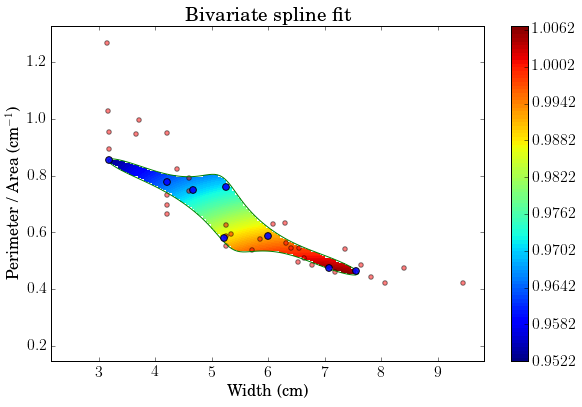

In [13]:
display_fit(width[reference], eqPonA[reference], factor[reference], model)
plt.scatter(width[check], eqPonA[check], c='red', alpha=0.5)

In [14]:
for i, value in enumerate(check):
    predictions[i] = model(width[value], eqPonA[value])
    give[i] = fit_give(
        width[value], eqPonA[value], 
        width[reference], eqPonA[reference], factor[reference])

percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

valid = give < 0.5

Mean = -0.10
Uncertainty = 0.37


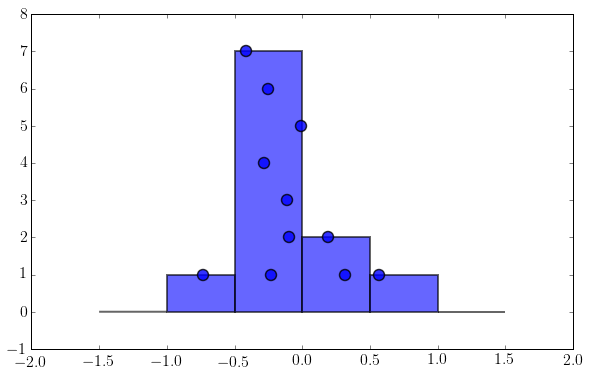

In [15]:
create_histogram(percent_prediction_differences[valid])

In [16]:
store = np.array([])
mean_diff = np.array([])
individual_std = np.array([])

In [31]:
amount = 8

for j in range(100000):
    order = np.arange(len(width))
    np.random.shuffle(order)
    reference = order[0:amount]
    reference
    check = np.setdiff1d(np.arange(len(width)), reference)
    check
    give = np.zeros(len(check))
    predictions = np.zeros(len(check))

    model = create_model(width[reference], eqPonA[reference], factor[reference])

    for i, value in enumerate(check):
        predictions[i] = model(width[value], eqPonA[value])
        give[i] = fit_give(
            width[value], eqPonA[value], 
            width[reference], eqPonA[reference], factor[reference])

    percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

    valid = give < 0.5
    store = np.append(store, percent_prediction_differences[valid])
    mean_diff = np.append(mean_diff, np.mean(percent_prediction_differences[valid]))
    individual_std = np.append(individual_std, np.std(percent_prediction_differences[valid]))

Mean = -0.01
Uncertainty = 0.46


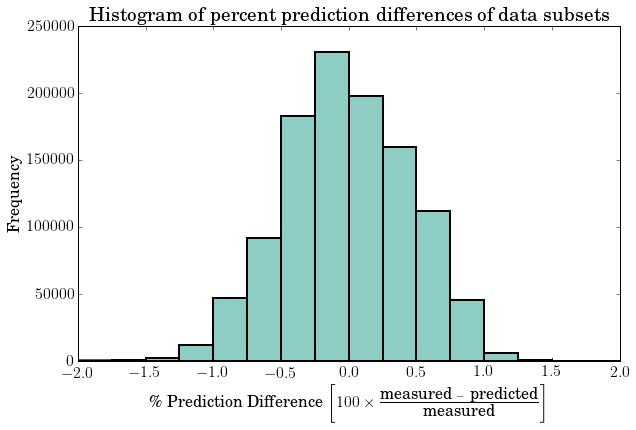

In [32]:
bins = np.arange(-2, 2.25, 0.25)

plt.figure(figsize=(6 * 1.618, 6))

plt.hist(store, bins, lw=2, fc=colour(0.55, alpha=0.5))

uncertainty = estimate_population_uncertainty(store)

print("Mean = %0.2f" % (np.mean(store)))
print("Uncertainty = %0.2f" % (uncertainty))

plt.xlabel(
    r'\% Prediction Difference '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of percent prediction differences of data subsets')

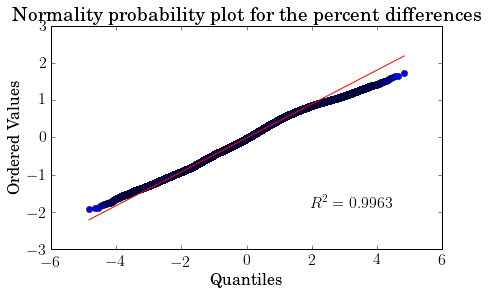

In [33]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(store, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

In [34]:
np.min(store)

-1.918523792464182

In [42]:
np.max(store)

1.7363885004867705

In [35]:
len(store)

1085319

In [36]:
mean_diff = mean_diff[~np.isnan(mean_diff)]

np.mean(np.abs(mean_diff))

0.18094326993879181

(array([  4.00000000e+00,   2.30000000e+01,   2.10000000e+02,
          3.69500000e+03,   2.53450000e+04,   4.49090000e+04,
          2.26850000e+04,   3.24300000e+03,   2.16000000e+02,
          1.50000000e+01]),
 array([-1.47577628, -1.206527  , -0.93727772, -0.66802844, -0.39877915,
        -0.12952987,  0.13971941,  0.40896869,  0.67821797,  0.94746725,
         1.21671654]),
 <a list of 10 Patch objects>)

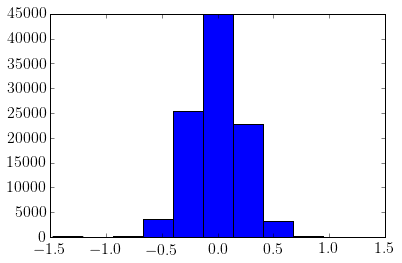

In [37]:
plt.hist(mean_diff)

In [38]:
np.std(mean_diff)

0.22783318802689279

In [39]:
individual_std = individual_std[~np.isnan(individual_std)]
np.mean(np.abs(individual_std))

0.37911454505776698

(array([  2.88200000e+03,   2.35600000e+03,   1.11260000e+04,
          3.81870000e+04,   3.38960000e+04,   9.91300000e+03,
          1.70500000e+03,   2.34000000e+02,   4.00000000e+01,
          6.00000000e+00]),
 array([ 0.        ,  0.09861082,  0.19722164,  0.29583247,  0.39444329,
         0.49305411,  0.59166493,  0.69027576,  0.78888658,  0.8874974 ,
         0.98610822]),
 <a list of 10 Patch objects>)

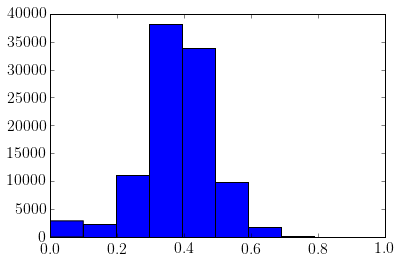

In [40]:
plt.hist(individual_std)

(array([  5.92000000e+02,   3.23800000e+03,   2.72190000e+04,
          4.24770000e+04,   2.13200000e+04,   4.78100000e+03,
          6.26000000e+02,   8.10000000e+01,   9.00000000e+00,
          2.00000000e+00]),
 array([  7.27768258e-04,   1.61562818e-01,   3.22397867e-01,
          4.83232916e-01,   6.44067966e-01,   8.04903015e-01,
          9.65738064e-01,   1.12657311e+00,   1.28740816e+00,
          1.44824321e+00,   1.60907826e+00]),
 <a list of 10 Patch objects>)

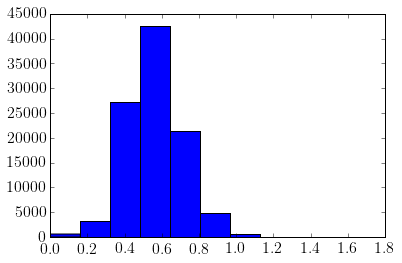

In [41]:
plt.hist(individual_std + np.abs(mean_diff))